In [1]:
import sys
from pathlib import Path
repo_root = Path.cwd().resolve().parent
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))
from src.utils.paths import load_paths
paths = load_paths()


## Block 1: Imports and Configuration

In [2]:
# === Block 1: Imports and Configuration ===

import pandas as pd
import os
import json
from pathlib import Path
import re
import unicodedata
from collections import Counter

# --- Configuration ---
PROCESSED_DATA_DIR = Path(paths['processed_dir'])
METADATA_PATH = paths['metadata_csv']
IMAGE_DIR = Path(paths['image_dir'])

# Output paths
FULL_DATA_JSON = PROCESSED_DATA_DIR / "final_data.json"
FILTERED_DATA_JSON = PROCESSED_DATA_DIR / "final_data_no_ixodes.json"
CLASS_NAMES_JSON = PROCESSED_DATA_DIR / "class_names.json"
FILTERED_CLASS_NAMES_JSON = PROCESSED_DATA_DIR / "class_names_no_ixodes.json"

# --- Change Log (populated during processing) ---
CHANGE_LOG = []

def log_change(category, message, details=None):
    """Log a data transformation for the final summary."""
    entry = {"category": category, "message": message}
    if details:
        entry["details"] = details
    CHANGE_LOG.append(entry)
    print(f"[{category}] {message}")

print("=" * 60)
print("TICK DATA EXPLORATION & CLEANING PIPELINE")
print("=" * 60)
print(f"Metadata CSV: {METADATA_PATH}")
print(f"Image directory: {IMAGE_DIR}")
print(f"Output directory: {PROCESSED_DATA_DIR}")
print("=" * 60)

TICK DATA EXPLORATION & CLEANING PIPELINE
Metadata CSV: /Users/jayjivandas/Research_Imageomics/BioClip/tick_classification_project/data/raw/AI Image Data Oct 31 2025.csv
Image directory: /Users/jayjivandas/Library/CloudStorage/OneDrive-TheOhioStateUniversity/Research-Onedrive/Imageomics/Bryant, Cece's files - Tick Images - Copy
Output directory: /Users/jayjivandas/Research_Imageomics/BioClip/tick_classification_project/data/processed


## Block 2: Load Raw Data

In [3]:
# === Block 2: Load Raw Data ===

# 1. Load CSV metadata
df_raw = pd.read_csv(METADATA_PATH)
n_raw_records = len(df_raw)
log_change("LOAD", f"Loaded {n_raw_records} records from CSV")

# 2. Check for duplicate Sample IDs
n_before_dedup = len(df_raw)
df = df_raw.drop_duplicates(subset=['Sample ID'], keep='first').copy()
n_after_dedup = len(df)
n_duplicates = n_before_dedup - n_after_dedup

if n_duplicates > 0:
    log_change("DEDUP", f"Removed {n_duplicates} duplicate Sample IDs (kept first occurrence)")
else:
    log_change("DEDUP", "No duplicate Sample IDs found")

# 3. Get all image filenames (case-insensitive lookup)
all_image_files = {f.upper(): f for f in os.listdir(IMAGE_DIR) if f.lower().endswith(('.jpg', '.jpeg', '.png'))}
log_change("LOAD", f"Found {len(all_image_files)} image files in directory")

# 4. Analyze image counts per specimen
image_id_counts = Counter()
for filename in all_image_files.values():
    parts = filename.split('-')
    if len(parts) >= 2:
        base_id = '-'.join(parts[:-1])
        image_id_counts[base_id] += 1

specimens_with_one_image = {id: count for id, count in image_id_counts.items() if count == 1}
specimens_with_two_images = {id: count for id, count in image_id_counts.items() if count == 2}
specimens_with_more_than_two = {id: count for id, count in image_id_counts.items() if count > 2}

print(f"\nImage count analysis:")
print(f"  Specimens with 1 image:  {len(specimens_with_one_image)} {list(specimens_with_one_image.keys()) if specimens_with_one_image else ''}")
print(f"  Specimens with 2 images: {len(specimens_with_two_images)}")
print(f"  Specimens with 3+ images: {len(specimens_with_more_than_two)} {list(specimens_with_more_than_two.keys()) if specimens_with_more_than_two else ''}")

if specimens_with_one_image:
    log_change("WARN", f"Specimens with only 1 image will be excluded: {list(specimens_with_one_image.keys())}")
if specimens_with_more_than_two:
    log_change("INFO", f"Specimens with 3+ images (extra images ignored): {list(specimens_with_more_than_two.keys())}")

[LOAD] Loaded 710 records from CSV
[DEDUP] Removed 7 duplicate Sample IDs (kept first occurrence)
[LOAD] Found 1827 image files in directory

Image count analysis:
  Specimens with 1 image:  2 ['246-01', '33-01']
  Specimens with 2 images: 911
  Specimens with 3+ images: 1 ['435-01']
[WARN] Specimens with only 1 image will be excluded: ['246-01', '33-01']
[INFO] Specimens with 3+ images (extra images ignored): ['435-01']


## Block 3: Cross-Reference CSV and Images

In [4]:
# === Block 3: Cross-Reference CSV and Images ===

# Get IDs from both sources
csv_ids = set(df['Sample ID'].astype(str))
image_base_ids = set(image_id_counts.keys())

# Find mismatches
ids_in_csv_not_in_images = csv_ids - image_base_ids
ids_in_images_not_in_csv = image_base_ids - csv_ids
valid_ids = csv_ids & image_base_ids

print("Cross-reference results:")
print(f"  Sample IDs in CSV:        {len(csv_ids)}")
print(f"  Base IDs from images:     {len(image_base_ids)}")
print(f"  Valid (in both):          {len(valid_ids)}")

if ids_in_csv_not_in_images:
    log_change("MISMATCH", f"CSV IDs with no images: {sorted(ids_in_csv_not_in_images)}")
if ids_in_images_not_in_csv:
    log_change("MISMATCH", f"Image IDs not in CSV: {sorted(ids_in_images_not_in_csv)}")

# Filter to valid IDs only
final_df = df[df['Sample ID'].isin(valid_ids)].copy()
log_change("FILTER", f"Proceeding with {len(final_df)} specimens that have matching CSV + image data")

Cross-reference results:
  Sample IDs in CSV:        703
  Base IDs from images:     914
  Valid (in both):          700
[MISMATCH] CSV IDs with no images: ['T17473', 'T19640', 'ZOE-0086-01']
[MISMATCH] Image IDs not in CSV: ['570-01', '575-01', '579-01', '582-01', '584-01', '585-01', '586-01', '587-01', '588-01', '589-01', '59-01', '590-01', '591-01', '593-01', '594-01', '596-01', '597-01', '598-01', '598-02', '600-01', '601-01', '602-01', '603-01', '604-01', '608-01', '609-01', '610-01', '612-01', '612-02', '613-01', '614-01', '615-01', '616-01', '617-01', '618-01', '619-01', '620-01', '622-01', '623-01', '624-01', '625-01', '625-02', '626-01', '627-01', '628-01', '629-01', '630-01', '631-01', '632-01', '633-01', '634-01', '635-01', '636-01', '637-01', '638-01', '639-01', '640-01', '641-01', '643-01', '643-02', 'T10129', 'T10136', 'T10154', 'T14337', 'T14496', 'T14497', 'T14498', 'T14499', 'T14511', 'T14512', 'T14517-01', 'T14517-02', 'T14518', 'T14534', 'T14540', 'T14551', 'T14552',

In [5]:
# === Block 4: Clean Species Labels ===

import re
import unicodedata

def normalize_spaces(s):
    """Normalize Unicode spaces and remove invisible characters."""
    s = unicodedata.normalize("NFKC", s or "")
    s = "".join(" " if unicodedata.category(ch).startswith("Z") else ch for ch in s)
    s = "".join(ch for ch in s if unicodedata.category(ch) not in {"Cc", "Cf"})
    return re.sub(r"\s+", " ", s).strip()

# Known typo patterns
TYPO_FIXES = {
    re.compile(r"^\s*dermacentor\s+variablis\s*$", re.I): "Dermacentor variabilis",
}

def fix_label(raw):
    """Clean species label: fix typos, normalize to 'Genus species' format."""
    s = normalize_spaces(raw)
    
    # Check for known typos first
    for pattern, replacement in TYPO_FIXES.items():
        if pattern.match(s):
            return replacement
    
    # Normalize to "Genus species" format
    parts = s.split()
    if len(parts) >= 2:
        return parts[0].capitalize() + " " + parts[1].lower()
    return s

# Apply label cleaning and track changes
label_changes = []
original_labels = final_df["Species of Tick"].astype(str)
cleaned_labels = original_labels.apply(fix_label)

for orig, clean in zip(original_labels, cleaned_labels):
    if orig != clean:
        label_changes.append((orig, clean))

final_df["true_label"] = cleaned_labels

# Log unique label transformations
unique_changes = list(set(label_changes))
if unique_changes:
    log_change("LABELS", f"Cleaned {len(label_changes)} labels ({len(unique_changes)} unique transformations)")
    for orig, clean in sorted(set(unique_changes)):
        print(f"    '{orig}' → '{clean}'")
else:
    log_change("LABELS", "No label corrections needed")

# Show raw label distribution
print("\nSpecies distribution (before filtering):")
label_counts = final_df["true_label"].value_counts()
for species, count in label_counts.items():
    pct = 100 * count / len(final_df)
    print(f"  {species}: {count} ({pct:.1f}%)")

[LABELS] Cleaned 277 labels (2 unique transformations)
    'Amblyomma americanum' → 'Amblyomma americanum'
    'Dermacentor variablis' → 'Dermacentor variabilis'

Species distribution (before filtering):
  Dermacentor variabilis: 308 (44.0%)
  Ixodes scapularis: 140 (20.0%)
  Amblyomma americanum: 90 (12.9%)
  Ixodes: 82 (11.7%)
  Haemaphysalis longicornis: 36 (5.1%)
  Ixodes cookei: 28 (4.0%)
  Ixodes dentatus: 9 (1.3%)
  Amblyomma maculatum: 6 (0.9%)
  Dermacentor andersoni: 1 (0.1%)


## Block 5: Build JSON Structure

In [6]:
# === Block 5: Build JSON Structure ===

final_data_list = []
class_names_set = set()
missing_image_ids = []
included_specimen_ids = []

for index, row in final_df.iterrows():
    base_id = row['Sample ID'].upper()
    dorsal_path, ventral_path = None, None

    # Try multiple filename patterns for dorsal/ventral
    dorsal_patterns = [f"{base_id}-01.JPG", f"{base_id}-1.JPG"]
    ventral_patterns = [f"{base_id}-02.JPG", f"{base_id}-2.JPG"]

    for pattern in dorsal_patterns:
        if pattern in all_image_files:
            original_filename = all_image_files[pattern]
            dorsal_path = str(IMAGE_DIR / original_filename)
            break
    
    for pattern in ventral_patterns:
        if pattern in all_image_files:
            original_filename = all_image_files[pattern]
            ventral_path = str(IMAGE_DIR / original_filename)
            break

    label = row["true_label"]
    
    # Only include specimens with BOTH dorsal and ventral images
    if dorsal_path and ventral_path:
        final_data_list.append({
            'image_path': dorsal_path,
            'true_label': label,
            'sample_id': row['Sample ID'],
            'view': 'dorsal',
            'sex': row.get('Tick Sex1', ''),
            'life_stage': row.get('Life Stage', ''),
            'attached': row.get('Attached?', '')
        })
        final_data_list.append({
            'image_path': ventral_path,
            'true_label': label,
            'sample_id': row['Sample ID'],
            'view': 'ventral',
            'sex': row.get('Tick Sex1', ''),
            'life_stage': row.get('Life Stage', ''),
            'attached': row.get('Attached?', '')
        })
        class_names_set.add(label)
        included_specimen_ids.append(row['Sample ID'])
    else:
        missing_image_ids.append(row['Sample ID'])

n_specimens = len(included_specimen_ids)
n_images = len(final_data_list)

log_change("BUILD", f"Created {n_images} image entries ({n_specimens} specimens × 2 views)")

if missing_image_ids:
    log_change("EXCLUDE", f"Excluded {len(missing_image_ids)} specimens missing dorsal/ventral pair: {missing_image_ids}")

[BUILD] Created 1396 image entries (698 specimens × 2 views)
[EXCLUDE] Excluded 2 specimens missing dorsal/ventral pair: ['246-01', '33-01']


## Block 6: Save Full Dataset

In [7]:
# === Block 6: Save Full Dataset ===

# Ensure output directory exists
PROCESSED_DATA_DIR.mkdir(parents=True, exist_ok=True)

# Save full data JSON
with open(FULL_DATA_JSON, 'w') as f:
    json.dump(final_data_list, f, indent=4)
log_change("SAVE", f"Saved full dataset to {FULL_DATA_JSON.name}")

# Save class names
final_class_names = sorted(list(class_names_set))
with open(CLASS_NAMES_JSON, 'w') as f:
    json.dump(final_class_names, f, indent=4)
log_change("SAVE", f"Saved {len(final_class_names)} species to {CLASS_NAMES_JSON.name}")

print(f"\nFull dataset species: {final_class_names}")

[SAVE] Saved full dataset to final_data.json
[SAVE] Saved 9 species to class_names.json

Full dataset species: ['Amblyomma americanum', 'Amblyomma maculatum', 'Dermacentor andersoni', 'Dermacentor variabilis', 'Haemaphysalis longicornis', 'Ixodes', 'Ixodes cookei', 'Ixodes dentatus', 'Ixodes scapularis']


## Block 7: Filter Incomplete Labels + Broken Specimens

In [ ]:
# === Block 7: Filter Incomplete Labels + Broken Specimens ===

# --- 1) Incomplete Labels ---
# "Ixodes" alone (without species) indicates incomplete identification
EXCLUDE_LABELS = {"Ixodes"}

# --- 2) Broken Specimens ---
# These specimens have data quality issues (wrong labels, corrupted images, etc.)
# Identified through error analysis - consistently misclassified across all runs
BROKEN_SPECIMEN_IDS = {
    "149-01",
    "ZOE-0021-01",
    "561-02",
    "560-01",
    "110-01",
    "224-01",
    "180-02",
    "419-01",
    "53-04",
    "503-01",
    "53-05",
    "33-02",
    "53-03",
    "53-02",
    "53-01",
    "290-01",
    "31-01",
}

# Count what we're removing - incomplete labels
excluded_by_label = [e for e in final_data_list if e['true_label'] in EXCLUDE_LABELS]
excluded_label_specimens = set(e['sample_id'] for e in excluded_by_label)

# Count what we're removing - broken specimens
excluded_by_broken = [e for e in final_data_list if e['sample_id'] in BROKEN_SPECIMEN_IDS]
excluded_broken_specimens = set(e['sample_id'] for e in excluded_by_broken)

log_change("FILTER", f"Removing {len(excluded_label_specimens)} specimens with incomplete labels: {EXCLUDE_LABELS}")
log_change("FILTER", f"Removing {len(excluded_broken_specimens)} broken specimens: {sorted(excluded_broken_specimens)}")

# Create filtered dataset (exclude BOTH incomplete labels AND broken specimens)
filtered_data_list = [
    e for e in final_data_list 
    if e['true_label'] not in EXCLUDE_LABELS and e['sample_id'] not in BROKEN_SPECIMEN_IDS
]
filtered_class_names = [name for name in final_class_names if name not in EXCLUDE_LABELS]

# Calculate totals
n_total_excluded = len(excluded_label_specimens | excluded_broken_specimens)
n_remaining = len(set(e['sample_id'] for e in filtered_data_list))

print(f"\nFiltering Summary:")
print(f"  Excluded by incomplete label: {len(excluded_label_specimens)} specimens")
print(f"  Excluded by broken data:      {len(excluded_broken_specimens)} specimens")
print(f"  Total excluded:               {n_total_excluded} specimens")
print(f"  Remaining:                    {n_remaining} specimens")

# Save filtered data
with open(FILTERED_DATA_JSON, 'w') as f:
    json.dump(filtered_data_list, f, indent=4)
log_change("SAVE", f"Saved filtered dataset to {FILTERED_DATA_JSON.name}")

with open(FILTERED_CLASS_NAMES_JSON, 'w') as f:
    json.dump(filtered_class_names, f, indent=4)
log_change("SAVE", f"Saved {len(filtered_class_names)} species to {FILTERED_CLASS_NAMES_JSON.name}")

print(f"\nFiltered dataset species: {filtered_class_names}")

[FILTER] Removing 82 specimens with incomplete labels: {'Ixodes'}
[FILTER] Removing 17 broken specimens: ['110-01', '149-01', '180-02', '224-01', '290-01', '31-01', '33-02', '419-01', '503-01', '53-01', '53-02', '53-03', '53-04', '53-05', '560-01', '561-02', 'ZOE-0021-01']

Filtering Summary:
  Excluded by incomplete label: 82 specimens
  Excluded by broken data:      17 specimens
  Total excluded:               99 specimens
  Remaining:                    599 specimens
[SAVE] Saved filtered dataset to final_data_no_ixodes.json
[SAVE] Saved 8 species to class_names_no_ixodes.json

Filtered dataset species: ['Amblyomma americanum', 'Amblyomma maculatum', 'Dermacentor andersoni', 'Dermacentor variabilis', 'Haemaphysalis longicornis', 'Ixodes cookei', 'Ixodes dentatus', 'Ixodes scapularis']


## Block 8: Data Visualization

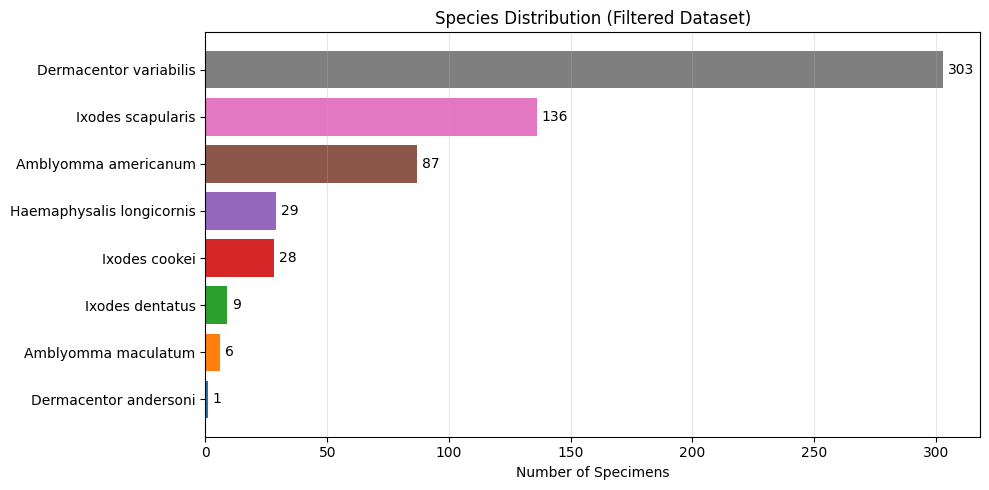

[VIZ] Saved species distribution bar chart to /Users/jayjivandas/Research_Imageomics/BioClip/tick_classification_project/data/processed/species_distribution.png


In [9]:
# === Block 8: Data Visualization ===

import matplotlib.pyplot as plt

# Build a DataFrame from the filtered data for visualization
viz_df = pd.DataFrame(filtered_data_list)

# Get unique specimens (one row per specimen, not per image)
specimen_df = viz_df.drop_duplicates(subset=['sample_id']).copy()

# --- Species Distribution Bar Chart ---
fig, ax = plt.subplots(figsize=(10, 5))

# Species counts
species_counts = specimen_df['true_label'].value_counts().sort_values(ascending=True)
colors = plt.cm.tab10(range(len(species_counts)))

bars = ax.barh(species_counts.index, species_counts.values, color=colors)
ax.set_xlabel('Number of Specimens')
ax.set_title('Species Distribution (Filtered Dataset)')
ax.grid(axis='x', alpha=0.3)

# Add count labels on bars
for bar, count in zip(bars, species_counts.values):
    ax.text(
        bar.get_width() + 2,
        bar.get_y() + bar.get_height() / 2,
        str(count),
        va='center',
        fontsize=10
    )

plt.tight_layout()
plt.savefig(PROCESSED_DATA_DIR / 'species_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

log_change(
    "VIZ",
    f"Saved species distribution bar chart to {PROCESSED_DATA_DIR / 'species_distribution.png'}"
)


## Block 9: Metadata Coverage

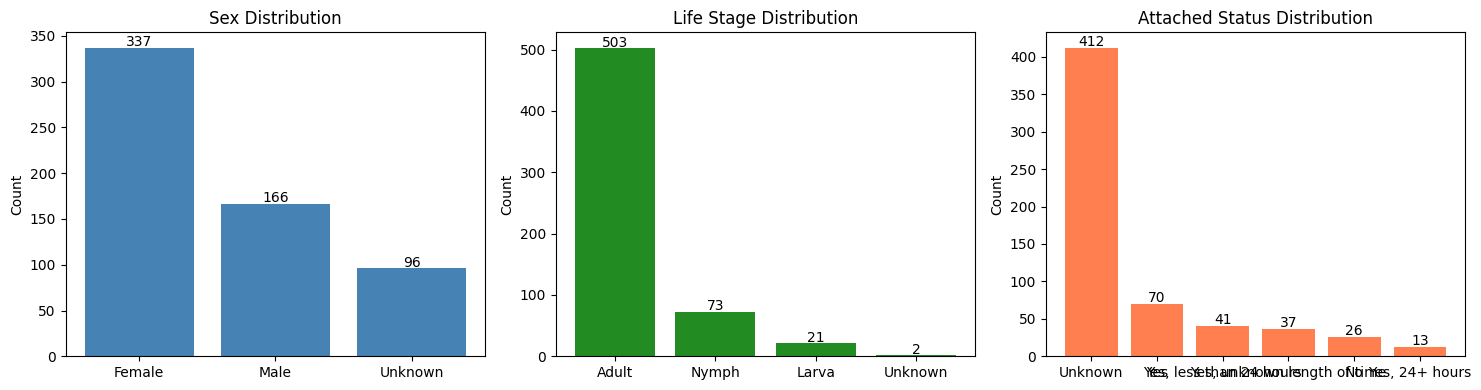

[VIZ] Saved metadata distribution plot to /Users/jayjivandas/Research_Imageomics/BioClip/tick_classification_project/data/processed/metadata_distribution.png

Metadata Coverage Summary:
  sex: 599/599 (100.0% filled)
  life_stage: 599/599 (100.0% filled)
  attached: 599/599 (100.0% filled)


In [10]:
# === Block 9: Metadata Coverage ===

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Helper to count values (treating empty strings as "Unknown")
def count_with_unknown(series, name):
    s = series.replace('', 'Unknown').fillna('Unknown')
    return s.value_counts()

# --- Sex Distribution ---
ax = axes[0]
sex_counts = count_with_unknown(specimen_df['sex'], 'sex')
ax.bar(sex_counts.index, sex_counts.values, color='steelblue')
ax.set_title('Sex Distribution')
ax.set_ylabel('Count')
for i, (label, count) in enumerate(sex_counts.items()):
    ax.text(i, count + 2, str(count), ha='center', fontsize=10)

# --- Life Stage Distribution ---
ax = axes[1]
stage_counts = count_with_unknown(specimen_df['life_stage'], 'life_stage')
ax.bar(stage_counts.index, stage_counts.values, color='forestgreen')
ax.set_title('Life Stage Distribution')
ax.set_ylabel('Count')
for i, (label, count) in enumerate(stage_counts.items()):
    ax.text(i, count + 2, str(count), ha='center', fontsize=10)

# --- Attached Status Distribution ---
ax = axes[2]
attached_counts = count_with_unknown(specimen_df['attached'], 'attached')
ax.bar(attached_counts.index, attached_counts.values, color='coral')
ax.set_title('Attached Status Distribution')
ax.set_ylabel('Count')
for i, (label, count) in enumerate(attached_counts.items()):
    ax.text(i, count + 2, str(count), ha='center', fontsize=10)

plt.tight_layout()
plt.savefig(PROCESSED_DATA_DIR / 'metadata_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

log_change("VIZ", f"Saved metadata distribution plot to {PROCESSED_DATA_DIR / 'metadata_distribution.png'}")

# Print metadata coverage summary
print("\nMetadata Coverage Summary:")
for col in ['sex', 'life_stage', 'attached']:
    filled = (specimen_df[col] != '').sum()
    total = len(specimen_df)
    pct = 100 * filled / total
    print(f"  {col}: {filled}/{total} ({pct:.1f}% filled)")

## Block 10: Final Summary

In [11]:
# === Block 10: Final Summary ===

from datetime import datetime

print("=" * 80)
print("DATA PROCESSING SUMMARY")
print("=" * 80)
print(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print()

# --- Source Data ---
print("SOURCE DATA")
print("-" * 40)
print(f"  Metadata CSV:     {Path(METADATA_PATH).name}")
print(f"  Image directory:  {IMAGE_DIR.name}")
print(f"  Records in CSV:   {n_raw_records}")
print(f"  Image files:      {len(all_image_files)}")
print()

# --- Processing Statistics ---
print("PROCESSING STATISTICS")
print("-" * 40)
print(f"  Specimens with 2 images:   {len(specimens_with_two_images)}")
print(f"  Specimens with 1 image:    {len(specimens_with_one_image)} (excluded)")
if specimens_with_one_image:
    print(f"    → {list(specimens_with_one_image.keys())}")
print(f"  Specimens with 3+ images:  {len(specimens_with_more_than_two)} (extra ignored)")
if specimens_with_more_than_two:
    print(f"    → {list(specimens_with_more_than_two.keys())}")
print()

# --- Species Distribution ---
print("SPECIES DISTRIBUTION (Full Dataset)")
print("-" * 40)
full_species_counts = pd.DataFrame(final_data_list).drop_duplicates('sample_id')['true_label'].value_counts()
for species, count in full_species_counts.items():
    pct = 100 * count / full_species_counts.sum()
    print(f"  {species:30s} {count:4d}  ({pct:5.1f}%)")
print(f"  {'TOTAL':30s} {full_species_counts.sum():4d}")
print()

# --- Filtering Summary ---
print("FILTERING SUMMARY")
print("-" * 40)
print(f"  Incomplete labels removed:  {len(excluded_label_specimens)} specimens")
print(f"  Broken specimens removed:   {len(excluded_broken_specimens)} specimens")
if excluded_broken_specimens:
    for sid in sorted(excluded_broken_specimens):
        print(f"    → {sid}")
print()

# --- Filtered Dataset ---
print("FILTERED DATASET (After All Filtering)")
print("-" * 40)
filtered_species_counts = specimen_df['true_label'].value_counts()
for species, count in filtered_species_counts.items():
    pct = 100 * count / filtered_species_counts.sum()
    print(f"  {species:30s} {count:4d}  ({pct:5.1f}%)")
print(f"  {'TOTAL':30s} {filtered_species_counts.sum():4d}")
print()

# --- Output Files ---
print("OUTPUT FILES")
print("-" * 40)
print(f"  {FULL_DATA_JSON.name:35s} {len(final_data_list):5d} entries ({len(final_data_list)//2} specimens)")
print(f"  {FILTERED_DATA_JSON.name:35s} {len(filtered_data_list):5d} entries ({len(filtered_data_list)//2} specimens)")
print(f"  {CLASS_NAMES_JSON.name:35s} {len(final_class_names):5d} species")
print(f"  {FILTERED_CLASS_NAMES_JSON.name:35s} {len(filtered_class_names):5d} species")
print()

# --- Change Log ---
print("CHANGE LOG")
print("-" * 40)
for entry in CHANGE_LOG:
    print(f"  [{entry['category']:8s}] {entry['message']}")

print()
print("=" * 80)
print("PIPELINE COMPLETE")
print("=" * 80)

DATA PROCESSING SUMMARY
Generated: 2026-02-07 19:16:15

SOURCE DATA
----------------------------------------
  Metadata CSV:     AI Image Data Oct 31 2025.csv
  Image directory:  Bryant, Cece's files - Tick Images - Copy
  Records in CSV:   710
  Image files:      1827

PROCESSING STATISTICS
----------------------------------------
  Specimens with 2 images:   911
  Specimens with 1 image:    2 (excluded)
    → ['246-01', '33-01']
  Specimens with 3+ images:  1 (extra ignored)
    → ['435-01']

SPECIES DISTRIBUTION (Full Dataset)
----------------------------------------
  Dermacentor variabilis          308  ( 44.1%)
  Ixodes scapularis               139  ( 19.9%)
  Amblyomma americanum             90  ( 12.9%)
  Ixodes                           82  ( 11.7%)
  Haemaphysalis longicornis        35  (  5.0%)
  Ixodes cookei                    28  (  4.0%)
  Ixodes dentatus                   9  (  1.3%)
  Amblyomma maculatum               6  (  0.9%)
  Dermacentor andersoni             1  